In [1]:
!pip install git+https://github.com/rtqichen/torchdiffeq

  Cloning https://github.com/rtqichen/torchdiffeq to /tmp/pip-req-build-l5yxupyt
  Running command git clone --filter=blob:none --quiet https://github.com/rtqichen/torchdiffeq /tmp/pip-req-build-l5yxupyt
  Resolved https://github.com/rtqichen/torchdiffeq to commit 8df757cb12f231a6b4349a96608b7a9d11166988
  Preparing metadata (setup.py) ... - done
  Created wheel for torchdiffeq: filename=torchdiffeq-0.2.3-py3-none-any.whl size=31200 sha256=11fdb1c41a0f09f39a5bb237ef3c370bd3ce53dff4f22a0d758abbe2e69a2f99
  Stored in directory: /tmp/pip-ephem-wheel-cache-bvv_23h3/wheels/42/b5/d4/aeb3622995bff5e90fcc0c0ef799a6951e48daaf17e293281e
Successfully built torchdiffeq


In [2]:
import numpy as np
import scipy.io
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from IPython.display import display, clear_output
gpu = '0'
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [3]:
block_size = 400
freq = 100
scaled = False

In [4]:
train_mat = scipy.io.loadmat('../input/aetraintanh/S_latent_train_20_AE_tanh.mat')
test_mat = scipy.io.loadmat('../input/dlrom20/S_latent_test_20_DLROM_p2_scaled.mat')
train_set = torch.tensor(train_mat['S'])
test_set = torch.tensor(test_mat['S'])

In [5]:
scaling = train_set.max() if scaled else 1
train_set_ = torch.unsqueeze(train_set,1)/scaling
test_set_ = torch.unsqueeze(test_set,1)/scaling
train_set_.shape

torch.Size([8000, 1, 2])

In [6]:
params_ = torch.linspace(5e-3,5e-2,20).unsqueeze(1)
params_test_ = torch.stack([(params_[i]+params_[i+1])/2 for i in range(19)])

params_blocked = torch.stack([params_[i,:] for i in range(20) for j in range(400)])
params_blocked_test = torch.stack([params_test_[i,:] for i in range(19) for j in range(400)])

params_blocked = params_blocked.unsqueeze(1)
params_blocked_test = params_blocked_test.unsqueeze(1)

params_blocked.shape, params_blocked_test.shape

train_set = torch.cat([train_set_, params_blocked],-1)
test_set = torch.cat([test_set_, params_blocked_test],-1)

train_set.shape, test_set.shape

(torch.Size([8000, 1, 3]), torch.Size([7600, 1, 3]))

In [7]:
def get_batch(batch_time):
    
    batch_t = torch.arange(batch_time).float()
    start_idx = torch.arange(0,8000,block_size)
    s = torch.from_numpy(np.random.choice(np.arange(block_size-batch_time), 20, replace=False))
    s = start_idx + s
    batch_u0 = train_set[s,:,:].float()
    batch_u = torch.stack([train_set_[s+i,:,:] for i in range(batch_time)]).float()

    return batch_u0.to(device), batch_u.to(device), batch_t.to(device), s.to(device)

In [8]:
def get_batch_test(batch_time):
    
    batch_t = torch.arange(batch_time).float()
    start_idx = torch.arange(0,7600,block_size)
    s = torch.from_numpy(np.random.choice(np.arange(block_size-batch_time), 19, replace=False))
    s = start_idx + s
    batch_u0 = test_set[s,:,:].float()
    batch_u = torch.stack([test_set_[s+i,:,:] for i in range(batch_time)]).float()

    return batch_u0.to(device), batch_u.to(device), batch_t.to(device), s.to(device)

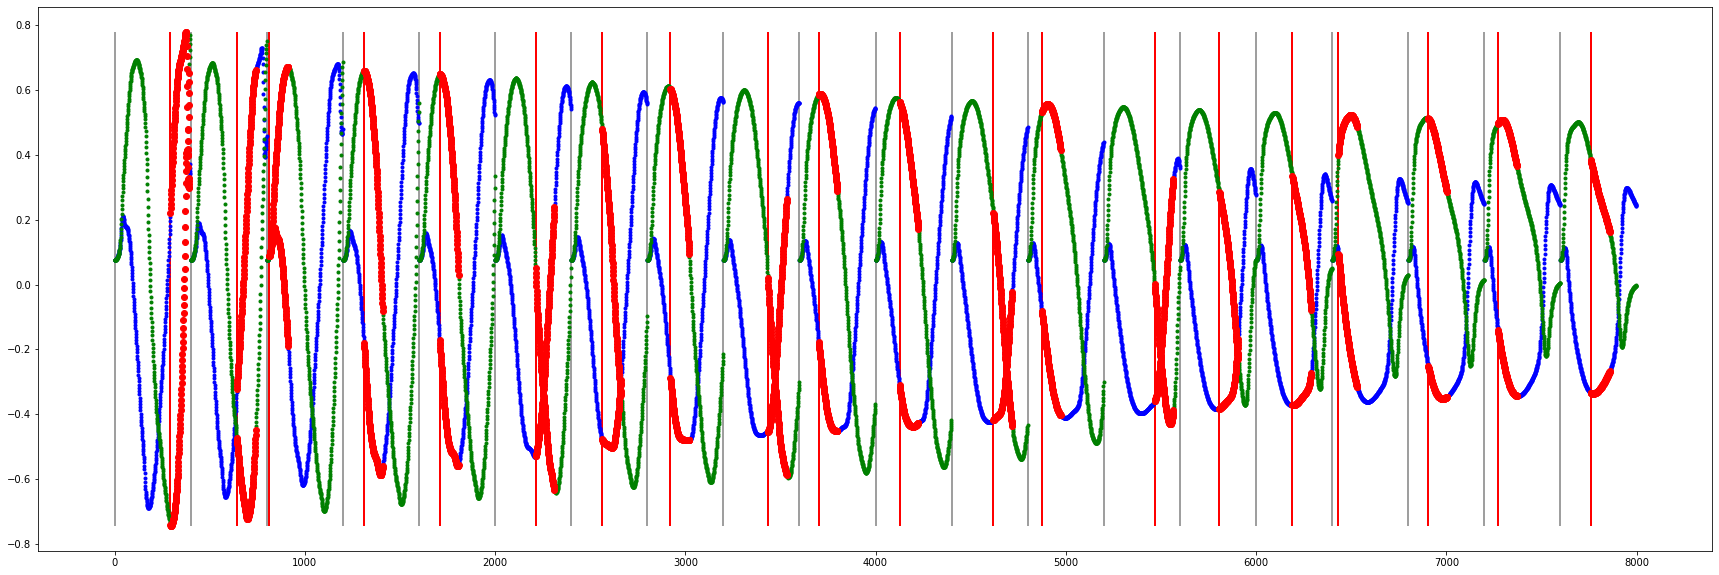

In [9]:
# VISUAL CHECK OF BATCHED DATA

with torch.no_grad():
    batch_u0, batch_u, batch_t, s = get_batch(100)

    plt.figure(figsize=(30,10))
    plt.vlines(np.arange(0,8000,400),train_set.min(),train_set.max(),color='gray')
    plt.vlines(s.cpu(),train_set.min(),train_set.max(),color='red',linewidth=2)
    plt.plot(train_set[:,:,0].cpu(),'.b')
    plt.plot(train_set[:,:,1].cpu(),'.g')
    for jj in range(20):
        plt.plot(s[jj].cpu()+batch_t.cpu(),batch_u[:,jj,:,0].cpu(),'or')
        plt.plot(s[jj].cpu()+batch_t.cpu(),batch_u[:,jj,:,1].cpu(),'or')

In [10]:
batch_u0.shape, batch_u.shape, batch_t.shape

(torch.Size([20, 1, 3]), torch.Size([100, 20, 1, 2]), torch.Size([100]))

In [11]:
class ODEfunc(nn.Module):
    def __init__(self,hidden_dim):
        super(ODEfunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(hidden_dim,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,hidden_dim),
        )
        
    def forward(self, t, y):
        return self.net(y)

In [12]:
class ODENet(nn.Module):
    def __init__(self, hidden_dim):
        super(ODENet, self).__init__()

        
        self.net1 = nn.Sequential(
            nn.Linear(3,32),
            nn.ELU(),
            nn.Linear(32,64),
            nn.ELU(),
            nn.Linear(64,hidden_dim)
        )

        self.ODEblock = ODEfunc(hidden_dim).to(device)

        self.net2 = nn.Sequential(
            nn.Linear(hidden_dim,64),
            nn.ELU(),
            nn.Linear(64,32),
            nn.ELU(),
            nn.Linear(32,2)
        )

        
    def forward(self, t, y):
        x = self.net1(y)
        x = odeint(self.ODEblock,x,t)
        x = self.net2(x)
        return x

In [13]:
func = ODENet(16).to(device)

In [14]:
def integrationtime_schedule(itr,maxinttime,mininttime,niters):
  return round(itr*(maxinttime-mininttime)/niters)+mininttime

In [15]:
lrate = 1e-3
niters = 10000
mininttime = 20
maxinttime = 350

itr_time = []
loss_array = []

optimizer = optim.Adam(func.parameters(), lr=lrate)

for itr in range(1, niters + 1):

        int_time = integrationtime_schedule(itr,maxinttime,mininttime,niters)
        start_itr = time.time()
        batch_u0, batch_u, batch_t, _ = get_batch(int_time)
        pred_u = func(batch_t,batch_u0)
        
        loss = torch.mean(torch.pow(pred_u - batch_u,2))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        itr_time.append(time.time()-start_itr)
        loss_array.append(loss.item())
        clear_output(wait=True)
        display('Iter ' + str(itr)+'/'+str(niters) + '  |  Loss: ' + str(round(loss.item(),6))+ ' | integr time: ' + str(int_time))

        if itr % freq == 0:
            with torch.no_grad():
                print('Iter ' + str(itr)+'/'+str(niters) + '\t|  Loss: ' + str(round(loss.item(),6)) + '\t|  lr: ' + str(optimizer.param_groups[0]['lr']) + '\t|  itr time: ' +str(round(itr_time[-1],5))+' s' + '\t integr time: '+str(int_time))
                #       visualize(true_u, pred_u, func, ii, batch_u0, batch_t)
                #       ii += 1


'Iter 10000/10000  |  Loss: 0.000519 | integr time: 350'

Iter 10000/10000	|  Loss: 0.000519	|  lr: 0.001	|  itr time: 2.17014 s	 integr time: 350


In [16]:
inttime_array = [integrationtime_schedule(itr,maxinttime,mininttime,niters) for itr in range(niters)]

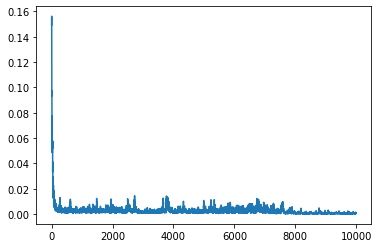

In [17]:
plt.plot(loss_array[2:])

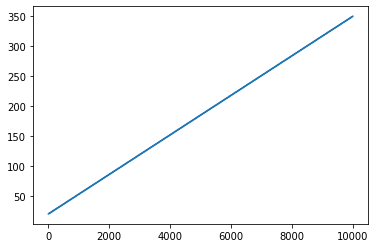

In [18]:
plt.plot(inttime_array[2:])

In [19]:
pred_u.shape

torch.Size([350, 20, 1, 2])

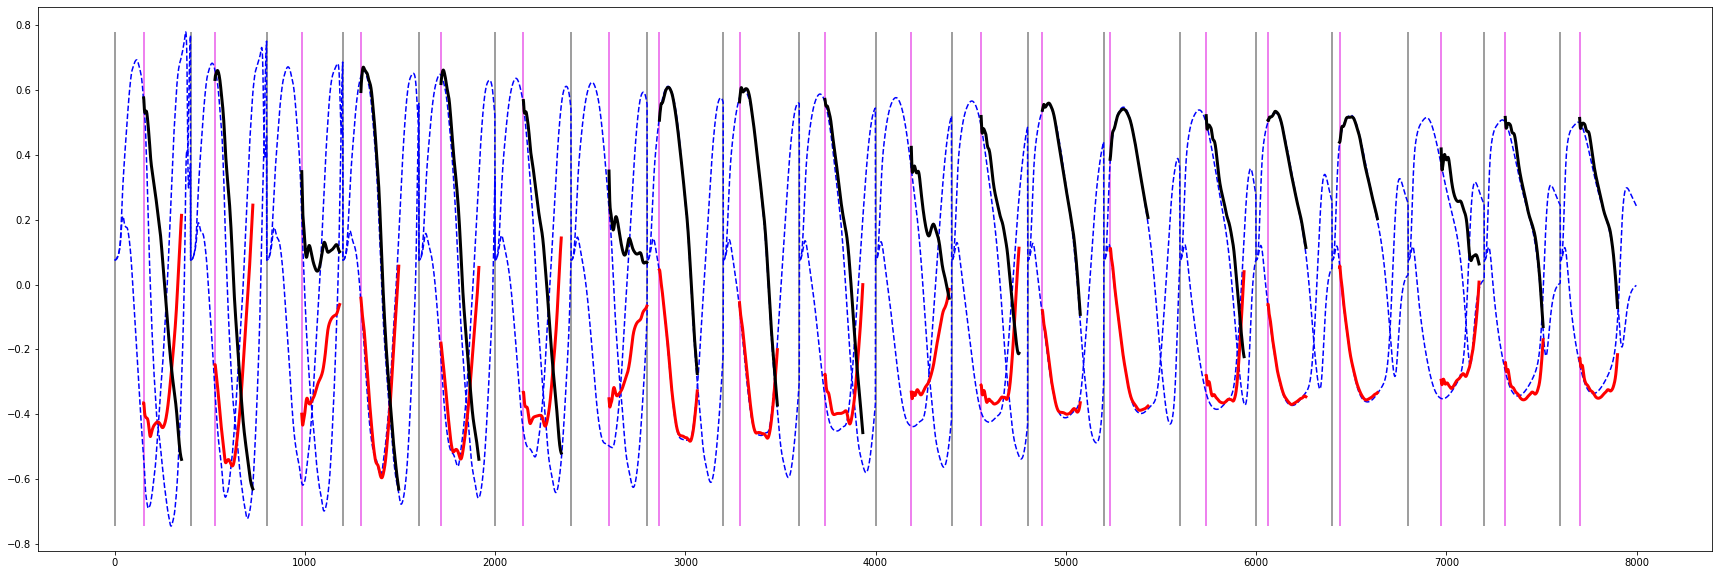

In [20]:
with torch.no_grad():
    batch_u0, batch_u, batch_t, s = get_batch(200)
    pred_u = func(batch_t,batch_u0)

    plt.figure(figsize=(30,10))
    plt.vlines(np.arange(0,8000,400),train_set.min(),train_set.max(),color='gray')
    plt.vlines(s.cpu(),train_set.min(),train_set.max(),color='violet',linewidth=2)
    plt.plot(train_set[:,:,0].cpu(),'--b')
    plt.plot(train_set[:,:,1].cpu(),'--b')
    for jj in range(20):
        #plt.plot(s[jj]+batch_t,batch_u[:,jj,:,0],'or')
        #plt.plot(s[jj]+batch_t,batch_u[:,jj,:,1],'or')
        plt.plot(s[jj].cpu()+batch_t.cpu(),pred_u[:,jj,:,0].cpu(),'-r',linewidth=3)
        plt.plot(s[jj].cpu()+batch_t.cpu(),pred_u[:,jj,:,1].cpu(),'-k',linewidth=3)

In [21]:
if False:
    with torch.no_grad():
        batch_u0, batch_u, batch_t, s = get_batch_test(350)
        pred_u = func(batch_t,batch_u0)

        plt.figure(figsize=(30,10))
        plt.vlines(np.arange(0,8000,400),test_set.min(),test_set.max(),color='gray')
        plt.vlines(s.cpu(),test_set.min(),test_set.max(),color='violet',linewidth=2)
        plt.plot(test_set[:,:,0].cpu(),'--b')
        plt.plot(test_set[:,:,1].cpu(),'--b')
        for jj in range(19):
            #plt.plot(s[jj]+batch_t,batch_u[:,jj,:,0],'or')
            #plt.plot(s[jj]+batch_t,batch_u[:,jj,:,1],'or')
            plt.plot(s[jj].cpu()+batch_t.cpu(),pred_u[:,jj,:,0].cpu(),'-r',linewidth=3)
            plt.plot(s[jj].cpu()+batch_t.cpu(),pred_u[:,jj,:,1].cpu(),'-k',linewidth=3)

In [22]:
torch.save(func, 'odefunc.pt')
torch.save(func.state_dict(), 'odefunc_sd.pt')
